In [3]:
import sys
from os.path import join
import numpy as np
import importlib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
PROJ_DIR = '/home/gcgreen2/alignment'
DALN_NEW = join(PROJ_DIR, 'test_sjs/da_out.txt')
DALN_GT = join(PROJ_DIR, 'test_sjs/NCTC1080_daligner_ground_truth.txt')

gt_df = pd.read_csv(DALN_GT, sep='\t', header=None, names=['i1','i2','overlap','l1','l2'])

In [11]:
gt_df.head(2)

,i1,i2,overlap,l1,l2
0,1,23,3395.0,8066,7885
1,1,116,5066.0,8066,22131


### format new daligner output

In [42]:
with open(DALN_NEW) as fh: 
    for _ in range(2): fh.readline()
    new_lines = fh.readlines()

In [43]:
new_lines[:2]

['     1      16 c   [ 1,959.. 6,067] x < 8,852.. 4,929]  ~  16.0%   (   643 diffs,  42 trace pts)\n',
 '     1      16 c   [ 6,136.. 8,066> x [ 4,802.. 2,883]  ~  15.8%   (   305 diffs,  20 trace pts)\n']

In [44]:
def parse_daln_line(line):
    line = line.split('~')[0].rstrip().lstrip()
    i1,i2 = line.split()[:2]
    line = ''.join(line.split()[3:])
    r1,r2 = line.split('x')
    ends = ('<' in r1 and '>' in r2) or ('>' in r1 and '<' in r2)
    line = r1[1:-1].replace(',','').split('..')
    overlap = abs(int(line[1])-int(line[0]))
    overlap_ends = overlap if ends else 0
    return [i1,i2,overlap,overlap_ends]

In [45]:
def add_duplicates(lines):
    i = 0
    while(i < len(lines)-1):
        cur_pair = lines[i][:2]
        next_pair = lines[i+1][:2]
        if cur_pair == next_pair:
            lines[i][2] += lines[i+1][2]
            lines[i][3] += lines[i+1][3]
            del lines[i+1]
        else: i += 1

In [46]:
new_lines = [parse_daln_line(l) for l in new_lines]
add_duplicates(new_lines)
new_df = pd.DataFrame(new_lines, columns=['i1','i2','overlap','overlap_ends'])
new_df.head(2)

,i1,i2,overlap,overlap_ends
0,1,16,6038,0
1,1,23,3395,3395


### Make dict of overlaps

In [72]:
overlaps = {}
for i in range(len(new_df)):
    line = new_df.iloc[i]
    pair = tuple([line.i1, line.i2])
    overlaps[pair] = [line.overlap, line.overlap_ends, 0]

for i in range(len(gt_df)):
    line = new_df.iloc[i]
    pair = tuple([line.i1, line.i2])
    if pair in overlaps:
        overlaps[pair][2] = line.overlap
    else:
        overlaps[pair] = [0, 0, line.overlap]
        
overlaps = np.array(list(overlaps.values()))

### scatterplots

In [73]:
overlaps

array([[ 6038,     0,  6038],
       [ 3395,  3395,  3395],
       [ 2924,     0,  2924],
       ...,
       [11313,     0,     0],
       [11142,     0,     0],
       [11742,     0,     0]])

Text(0.5, 1.0, 'New vs. GT')

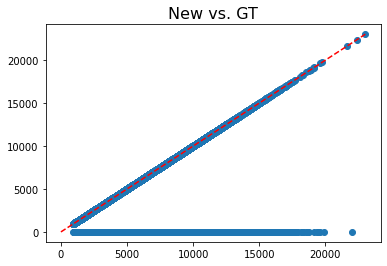

In [81]:
plt.scatter(x=overlaps[:,0], y=overlaps[:,2])
plt.plot([0,max(overlaps[:,0])], [0,max(overlaps[:,0])], '--', color='red')
plt.title('New vs. GT',fontsize=16)

Text(0.5, 1.0, 'New (ends only) vs. GT')

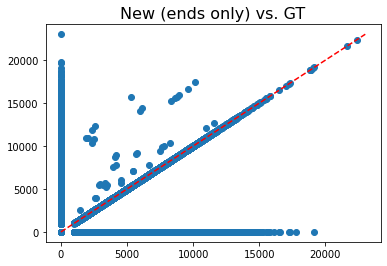

In [83]:
plt.scatter(x=overlaps[:,1], y=overlaps[:,2])
plt.plot([0,max(overlaps[:,0])], [0,max(overlaps[:,0])], '--', color='red')
plt.title('New (ends only) vs. GT',fontsize=16)

In [86]:
pct_equal = 100*np.count_nonzero(np.isclose(overlaps[:,0],overlaps[:,2], atol=10)) / len(overlaps)
print('{:.2f}% equal'.format(pct_equal))

61.03% equal
